# 02 LIANA tumor vs normal core atlas 
### Load DESEQ2 results to obtain significant interactions 

## 00. Libraries

In [1]:
import numpy as  np
import pandas as pd
import scanpy as sc
import decoupler as dc
import liana as li
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import sc_atlas_helpers as ah
from tqdm.auto import tqdm
import contextlib
import os
import statsmodels.stats.multitest
import numpy as np
from anndata import AnnData
import scipy.sparse

/home/kvalem/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 01. Define variables, paths and comparison tumor vs normal

In [4]:
comparison="tumor_normal"
subset = "core_atlas" 
cell_type_oi = "Cancer cell"
n_top_ligands = 30

In [5]:
perturbation = comparison.split("_")[0].upper()
baseline = comparison.split("_")[1].upper()
title_plot = f"{perturbation} vs {baseline}: {cell_type_oi}, top {n_top_ligands} DE ligands"
cell_type_oi = cell_type_oi.replace(" ","")
save_name_plot =  f"{perturbation}_vs_{baseline}_{cell_type_oi}_top_{n_top_ligands}_DE_ligands"

In [6]:
dataDir = f"/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/{subset}/{comparison}"
resDir = dataDir

In [7]:
resDir

'/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/core_atlas/tumor_normal'

In [8]:
dataDir

'/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/core_atlas/tumor_normal'

## 03. Functions

In [26]:
def fdr_correction(df, pvalue_col="pvalue", *, key_added="fdr", inplace=False):
    """Adjust p-values in a data frame with test results using FDR correction."""
    if not inplace:
        df = df.copy()

    df[key_added] = statsmodels.stats.multitest.fdrcorrection(df[pvalue_col].values)[1]

    if not inplace:
        return df

In [27]:
"""Plotting functions for group comparisons"""

import altair as alt
import pandas as pd
import numpy as np


def plot_lm_result_altair(
    df,
    p_cutoff=0.1,
    p_col="fdr",
    x="variable",
    y="group",
    color="coef",
    title="heatmap",
    cluster=False,
    value_max=None,
    configure=lambda x: x.configure_mark(opacity=1),
    cmap="redblue",
    reverse=True,
    domain=lambda x: [-x, x],
    order=None,
):
    """
    Plot a results data frame of a comparison as a heatmap
    """
    df_filtered = df.loc[lambda _: _[p_col] < p_cutoff, :]
    df_subset = df.loc[
        lambda _: _[x].isin(df_filtered[x].unique()) & _[y].isin(df[y].unique())
    ]
    if not df_subset.shape[0]:
        print("No values to plot")
        return

    if order is None:
        order = "ascending"
        if cluster:
            from scipy.cluster.hierarchy import linkage, leaves_list

            values_df = df_subset.pivot(index=y, columns=x, values=color)
            order = values_df.columns.values[
                leaves_list(
                    linkage(values_df.values.T, method="average", metric="euclidean")
                )
            ]

    def _get_significance(fdr):
        if fdr < 0.001:
            return "< 0.001"
        elif fdr < 0.01:
            return "< 0.01"
        elif fdr < 0.1:
            return "< 0.1"
        else:
            return np.nan

    df_subset["FDR"] = pd.Categorical([_get_significance(x) for x in df_subset[p_col]])

    if value_max is None:
        value_max = max(
            abs(np.nanmin(df_subset[color])), abs(np.nanmax(df_subset[color]))
        )
    # just setting the domain in altair will lead to "black" fields. Therefore, we constrain the values themselves.
    df_subset[color] = np.clip(df_subset[color], *domain(value_max))
    return configure(
        alt.Chart(df_subset, title=title)
        .mark_rect()
        .encode(
            x=alt.X(x, sort=order),
            y=y,
            color=alt.Color(
                color,
                scale=alt.Scale(scheme=cmap, reverse=reverse, domain=domain(value_max)),
            ),
        )
        + alt.Chart(df_subset.loc[lambda x: ~x["FDR"].isnull()])
        .mark_point(color="white", filled=True, stroke="black", strokeWidth=0)
        .encode(
            x=alt.X(x, sort=order),
            y=y,
            size=alt.Size(
                "FDR:N",
                scale=alt.Scale(
                    domain=["< 0.001", "< 0.01", "< 0.1"],
                    range=4 ** np.array([3, 2, 1]),
                ),
            ),
        )
    )

In [28]:
from typing import Sequence, Union
from anndata import AnnData, ImplicitModificationWarning
import numpy as np
import pandas as pd
from operator import and_
from functools import reduce
import warnings


def pseudobulk(
    adata,
    *,
    groupby: Union[str, Sequence[str]],
    aggr_fun=np.sum,
    min_obs=10,
) -> AnnData:
    """
    Calculate Pseudobulk of groups

    Parameters
    ----------
    adata
        annotated data matrix
    groupby
        One or multiple columns to group by
    aggr_fun
        Callback function to calculate pseudobulk. Must be a numpy ufunc supporting
        the `axis` attribute.
    min_obs
        Exclude groups with less than `min_obs` observations

    Returns
    -------
    New anndata object with same vars as input, but reduced number of obs.
    """
    if isinstance(groupby, str):
        groupby = [groupby]

    combinations = adata.obs.loc[:, groupby].drop_duplicates()

    if adata.is_view:
        # for whatever reason, the pseudobulk function is terribly slow when operating on a view.
        adata = adata.copy()

    # precompute masks
    masks = {}
    for col in groupby:
        masks[col] = {}
        for val in combinations[col].unique():
            masks[col][val] = adata.obs[col] == val

    expr_agg = []
    obs = []

    for comb in combinations.itertuples(index=False):
        mask = reduce(and_, (masks[col][val] for col, val in zip(groupby, comb)))
        if np.sum(mask) < min_obs:
            continue
        expr_row = aggr_fun(adata.X[mask, :], axis=0)
        obs_row = comb._asdict()
        obs_row["n_obs"] = np.sum(mask)
        # convert matrix to array if required (happens when aggregating spares matrix)
        try:
            expr_row = expr_row.A1
        except AttributeError:
            pass
        obs.append(obs_row)
        expr_agg.append(expr_row)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ImplicitModificationWarning)
        return AnnData(
            X=np.vstack(expr_agg),
            var=adata.var,
            obs=pd.DataFrame.from_records(obs),
        )

In [29]:
"""Helper functions for cellphonedb analysis

Focuses on differential cellphonedb analysis between conditions.
"""
from typing import List, Literal
import pandas as pd
#from .pseudobulk import pseudobulk
import numpy as np
import scanpy as sc
import altair as alt
#from .compare_groups.pl import plot_lm_result_altair
#from .util import fdr_correction


class CpdbAnalysis:
    def __init__(
        self, cpdb, adata, *, pseudobulk_group_by: List[str], cell_type_column: str
    ):
        """
        Class that handles comparative cellphonedb analysis.

        Parameters
        ----------
        cpdb
            pandas data frame with cellphonedb interactions.
            Required columns: `source_genesymbols`, `target_genesymbol`.
            You can get this from omnipathdb:
            https://omnipathdb.org/interactions/?fields=sources,references&genesymbols=1&databases=CellPhoneDB
        adata
            Anndata object with the target cells. Will use this to derive mean fraction of expressed cells.
            Should contain counts in X.
        pseudobulk_group_by
            See :func:`scanpy_helper.pseudobulk.pseudobulk`. Pseudobulk is used to compute the mean fraction
            of expressed cells by patient
        cell_type_column
            Column in anndata that contains the cell-type annotation.
        """
        self.cpdb = cpdb
        self.cell_type_column = cell_type_column
        self._find_expressed_genes(adata, pseudobulk_group_by)

    def _find_expressed_genes(self, adata, pseudobulk_group_by):
        """Compute the mean expression and fraction of expressed cells per cell-type.
        This is performed on the pseudobulk level, i..e. the mean of means per patient is calculated.
        """
        pb_fracs = pseudobulk(
            adata,
            groupby=pseudobulk_group_by + [self.cell_type_column],
            aggr_fun=lambda x, axis: np.sum(x > 0, axis) / x.shape[axis],  # type: ignore
        )
        fractions_expressed = pseudobulk(
            pb_fracs, groupby=self.cell_type_column, aggr_fun=np.mean
        )
        fractions_expressed.obs.set_index(self.cell_type_column, inplace=True)

        pb = pseudobulk(
            adata,
            groupby=pseudobulk_group_by + [self.cell_type_column],
        )
        sc.pp.normalize_total(pb, target_sum=1e6)
        sc.pp.log1p(pb)
        pb_mean_cell_type = pseudobulk(
            pb, groupby=self.cell_type_column, aggr_fun=np.mean
        )
        pb_mean_cell_type.obs.set_index(self.cell_type_column, inplace=True)

        self.expressed_genes = (
            fractions_expressed.to_df()
            .melt(ignore_index=False, value_name="fraction_expressed")
            .reset_index()
            .merge(
                pb_mean_cell_type.to_df()
                .melt(ignore_index=False, value_name="expr_mean")
                .reset_index(),
                on=[self.cell_type_column, "variable"],
            )
        )

    def significant_interactions(
        self,
        de_res: pd.DataFrame,
        *,
        pvalue_col="pvalue",
        fc_col="log2FoldChange",
        gene_symbol_col="gene_id",
        max_pvalue=0.1,
        min_abs_fc=1,
        adjust_fdr=True,
        min_frac_expressed=0.1,
        de_genes_mode: Literal["ligand", "receptor"] = "ligand",
    ) -> pd.DataFrame:
        """
        Generates a data frame of differentiall cellphonedb interactions.

        This function will extract all known ligands (or receptors, respectively) from a list of differentially expressed
        and find all receptors (or ligands, respectively) that are expressed above a certain cutoff in all cell-types.

        Parameters:
        -----------
        de_res
            List of differentially expressed genes
        pvalue_col
            column in de_res that contains the pvalue or false discovery rate
        gene_id_col
            column in de_res that contains the gene symbol
        min_frac_expressed
            Minimum fraction cells that need to express the receptor (or ligand) to be considered a potential interaction
        de_genes_mode
            If the list of de genes provided are ligands (default) or receptors. In case of `ligand`, cell-types
            that express corresonding receptors above the threshold will be identified. In case of `receptor`,
            cell-types that express corresponding ligands above the threshold will be identified.
        adjust_fdr
            If True, calculate false discovery rate on the pvalue, after filtering for genes that are contained
            in the cellphonedb.
        """
        if de_genes_mode == "ligand":
            cpdb_de_col = "source_genesymbol"
            cpdb_expr_col = "target_genesymbol"
        elif de_genes_mode == "receptor":
            cpdb_de_col = "target_genesymbol"
            cpdb_expr_col = "source_genesymbol"
        else:
            raise ValueError("Invalud value for de_genes_mode!")

        de_res = de_res.loc[lambda x: x[gene_symbol_col].isin(self.cpdb[cpdb_de_col])]
        if adjust_fdr:
            de_res = fdr_correction(de_res, pvalue_col=pvalue_col, key_added="fdr")
            pvalue_col = "fdr"

        significant_genes = de_res.loc[
            lambda x: (x[pvalue_col] < max_pvalue) & (np.abs(x[fc_col]) >= min_abs_fc),
            gene_symbol_col,
        ].unique()  # type: ignore
        significant_interactions = self.cpdb.loc[
            lambda x: x[cpdb_de_col].isin(significant_genes)
        ]

        res_df = (
            self.expressed_genes.loc[
                lambda x: x["fraction_expressed"] >= min_frac_expressed
            ]  # type: ignore
            .merge(
                significant_interactions,
                left_on="variable",
                right_on=cpdb_expr_col,
            )
            .drop(columns=["variable"])
            .merge(de_res, left_on=cpdb_de_col, right_on=gene_symbol_col)
            .drop(columns=[gene_symbol_col])
        )

        return res_df

    def plot_result(
        self,
        cpdb_res,
        *,
        pvalue_col="fdr",
        group_col="group",
        fc_col="log2FoldChange",
        title="CPDB analysis",
        aggregate=True,
        clip_fc_at=(-5, 5),
        label_limit=100,
        cluster: Literal["heatmap", "dotplot"] = "dotplot",
        de_genes_mode: Literal["ligand", "receptor"] = "ligand",
    ):
        """
        Plot cpdb results as heatmap

        Parameters
        ----------
        cpdb_res
            result of `significant_interactions`. May be further filtered or modified.
        group_col
            column to be used for the y axis of the heatmap
        aggregate
            whether to merge multiple targets of the same ligand into a single column
        de_genes_mode
            If the list of de genes provided are ligands (default) or receptors. If receptor, will show the dotplot
            at the top (source are expressed ligands) and the de heatmap at the bottom (target are the DE receptors).
            Otherwise the other way round.
        """
        if de_genes_mode == "ligand":
            cpdb_de_col = "source_genesymbol"
            cpdb_expr_col = "target_genesymbol"
        elif de_genes_mode == "receptor":
            cpdb_de_col = "target_genesymbol"
            cpdb_expr_col = "source_genesymbol"
        else:
            raise ValueError("Invalud value for de_genes_mode!")

        cpdb_res[fc_col] = np.clip(cpdb_res[fc_col], *clip_fc_at)

        # aggregate if there are multiple receptors per ligand
        if aggregate:
            cpdb_res = (
                cpdb_res.groupby(
                    [
                        self.cell_type_column,
                        cpdb_de_col,
                        fc_col,
                        pvalue_col,
                        group_col,
                    ]
                )
                .agg(
                    n=(cpdb_expr_col, len),
                    fraction_expressed=("fraction_expressed", np.max),
                    expr_mean=("expr_mean", np.max),
                )
                .reset_index()
                .merge(
                    cpdb_res.groupby(cpdb_de_col).agg(
                        **{
                            cpdb_expr_col: (
                                cpdb_expr_col,
                                lambda x: "|".join(np.unique(x)),
                            )
                        }
                    ),
                    on=cpdb_de_col,
                )
            )

        cpdb_res["interaction"] = [
            f"{s}_{t}" for s, t in zip(cpdb_res[cpdb_de_col], cpdb_res[cpdb_expr_col])
        ]

        # cluster heatmap
        if cluster is not None:
            from scipy.cluster.hierarchy import linkage, leaves_list

            _idx = self.cell_type_column if cluster == "dotplot" else group_col
            _values = "fraction_expressed" if cluster == "dotplot" else fc_col
            _columns = "interaction"
            values_df = (
                cpdb_res.loc[:, [_idx, _values, _columns]]
                .drop_duplicates()
                .pivot(
                    index=_idx,
                    columns=_columns,
                    values=_values,
                )
                .fillna(0)
            )
            order = values_df.columns.values[
                leaves_list(
                    linkage(values_df.values.T, method="average", metric="euclidean")
                )
            ]
        else:
            order = "ascending"

        p1 = plot_lm_result_altair(
            cpdb_res,
            color=fc_col,
            p_col=pvalue_col,
            x="interaction",
            configure=lambda x: x,
            title="",
            order=order,
            p_cutoff=1,
        ).encode(
            x=alt.X(
                title=None,
                axis=alt.Axis(
                    labelExpr="split(datum.label, '_')[0]",
                    orient="top" if de_genes_mode == "receptor" else "bottom",
                ),
            )
        )

        p2 = (
            alt.Chart(cpdb_res)
            .mark_circle()
            .encode(
                x=alt.X(
                    "interaction",
                    axis=alt.Axis(
                        grid=True,
                        orient="bottom" if de_genes_mode == "receptor" else "top",
                        title=None,
                        labelExpr="split(datum.label, '_')[1]",
                        labelLimit=label_limit,
                    ),
                    sort=order,
                ),
                y=alt.Y(self.cell_type_column, axis=alt.Axis(grid=True), title=None),
                size=alt.Size("fraction_expressed"),
                color=alt.Color("expr_mean", scale=alt.Scale(scheme="cividis")),
            )
        )

        if de_genes_mode == "receptor":
            p1, p2 = p2, p1

        return (
            alt.vconcat(p1, p2, title=title)
            .resolve_scale(size="independent", color="independent", x="independent")
            .configure_mark(opacity=1)
            .configure_concat(spacing=label_limit - 130)
        )

## 04. Load adata with LIANA ranked information 

In [11]:
dataDir ="/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/h5ads/"

In [12]:
adata = sc.read_h5ad(f"{dataDir}/adata_rank_agregate.h5ad")

## 05. Load DESEQ2 results

In [41]:
# DESEQ2 output path 
deseq2_path_prefix = "/data/projects/2022/CRCA/results/v1/final/liana_cell2cell/core_atlas/tumor_normal/epithelial_cancer/03_deseq2/"

In [42]:
file_name_deseq2_out = "Cancer_Epithelial_tumor_vs_normal_DESeq2_result.tsv"

In [43]:
de_res = (
    pd.read_csv(f"{deseq2_path_prefix}/{file_name_deseq2_out}",
        sep="\t",
    )
    .fillna(1)
    #.pipe(fdr_correction)
    .rename(columns={"comparison": "group"})
)

## 06. Get significant interactions 

In [44]:
cpdb_res = adata.uns['rank_aggregate'].loc[
        lambda x: x["specificity_rank"] <= 0.01
    ]
cpdb_res=cpdb_res.rename(columns={"ligand_complex":"source_genesymbol","receptor_complex":"target_genesymbol"})

cpdba = CpdbAnalysis(
    cpdb_res,
    adata,
    pseudobulk_group_by=["patient_id"],
    cell_type_column="cell_type_fine"
)

cpdb_sig_int = cpdba.significant_interactions(
    de_res, max_pvalue=0.1
)

In [45]:
cpdb_sig_int

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,magnitude_rank,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,group,fdr
0,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,0.001159,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,0.000739,0.965047,tumor_vs_normal,0.000587
1,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Epithelial progenitor,L1CAM,EPHB2,1.199925,0.0,0.652136,...,0.001473,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,0.000739,0.965047,tumor_vs_normal,0.000587
2,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Cancer cell,L1CAM,EPHB2,1.192190,0.0,0.619844,...,0.003412,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,0.000739,0.965047,tumor_vs_normal,0.000587
3,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Tuft,L1CAM,EPHB2,1.158540,0.0,0.479359,...,0.024920,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,0.000739,0.965047,tumor_vs_normal,0.000587
4,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Goblet,L1CAM,EPHB2,1.126360,0.0,0.345009,...,0.051496,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,0.000739,0.965047,tumor_vs_normal,0.000587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,Mast cell,1.000000,7.343494,Dendritic cell,Mast cell,IL23A,SIGLEC6,0.917188,0.0,0.102859,...,0.991822,4.817132,1.871434,0.349719,5.351255,8.734644e-08,0.000002,1.082748,tumor_vs_normal,0.000001
3673,Mast cell,0.528813,4.752830,Macrophage,Macrophage,LILRB4,LAIR1,0.629919,0.0,0.393494,...,0.060528,7.960916,3.311670,0.723468,4.577494,4.705784e-06,0.000063,0.949329,tumor_vs_normal,0.000045
3674,CD8,0.108087,3.220831,Macrophage,Macrophage,LILRB4,LAIR1,0.629919,0.0,0.393494,...,0.060528,7.960916,3.311670,0.723468,4.577494,4.705784e-06,0.000063,0.949329,tumor_vs_normal,0.000045
3675,Macrophage,0.817357,5.369631,Macrophage,Macrophage,LILRB4,LAIR1,0.629919,0.0,0.393494,...,0.060528,7.960916,3.311670,0.723468,4.577494,4.705784e-06,0.000063,0.949329,tumor_vs_normal,0.000045


In [46]:
cpdb_sig_int_unique = cpdb_sig_int.drop_duplicates(subset=["source", "target"])

In [47]:
cpdb_sig_int_unique

,cell_type_fine,fraction_expressed,expr_mean,source,target,source_genesymbol,target_genesymbol,lr_means,cellphone_pvals,expr_prod,...,magnitude_rank,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,weight,group,fdr
0,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Enteroendocrine,L1CAM,EPHB2,1.215765,0.0,0.718264,...,0.001159,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,7.389376e-04,0.965047,tumor_vs_normal,5.865334e-04
1,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Epithelial progenitor,L1CAM,EPHB2,1.199925,0.0,0.652136,...,0.001473,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,7.389376e-04,0.965047,tumor_vs_normal,5.865334e-04
2,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Cancer cell,L1CAM,EPHB2,1.192190,0.0,0.619844,...,0.003412,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,7.389376e-04,0.965047,tumor_vs_normal,5.865334e-04
3,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Tuft,L1CAM,EPHB2,1.158540,0.0,0.479359,...,0.024920,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,7.389376e-04,0.965047,tumor_vs_normal,5.865334e-04
4,Cancer Crypt-like,0.820453,4.621913,Schwann cell,Goblet,L1CAM,EPHB2,1.126360,0.0,0.345009,...,0.051496,7.850310,-2.030870,0.519845,-3.906684,9.357147e-05,7.389376e-04,0.965047,tumor_vs_normal,5.865334e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,Cancer Crypt-like,0.277172,2.864184,Macrophage,Cancer cell,C1QB,C1QBP,0.891892,0.0,0.095174,...,0.419999,15.947549,7.178462,1.048771,6.844644,7.666616e-12,8.451537e-10,1.045319,tumor_vs_normal,1.970320e-10
3580,Fibroblast S3,0.106616,2.707771,Epithelial cell,Endothelial cell,CD177,PECAM1,1.074810,0.0,0.728937,...,0.002809,16.093655,-5.803496,0.608637,-9.535231,1.495526e-21,1.242863e-18,1.086171,tumor_vs_normal,9.608754e-20
3670,Mast cell,1.000000,7.343494,CD4,Mast cell,IL23A,SIGLEC6,0.939974,0.0,0.183818,...,0.565344,4.817132,1.871434,0.349719,5.351255,8.734644e-08,2.110126e-06,1.082748,tumor_vs_normal,1.181476e-06
3671,Mast cell,1.000000,7.343494,Treg,Mast cell,IL23A,SIGLEC6,0.924925,0.0,0.130349,...,0.931261,4.817132,1.871434,0.349719,5.351255,8.734644e-08,2.110126e-06,1.082748,tumor_vs_normal,1.181476e-06


<Axes: xlabel='log2FoldChange', ylabel='Count'>

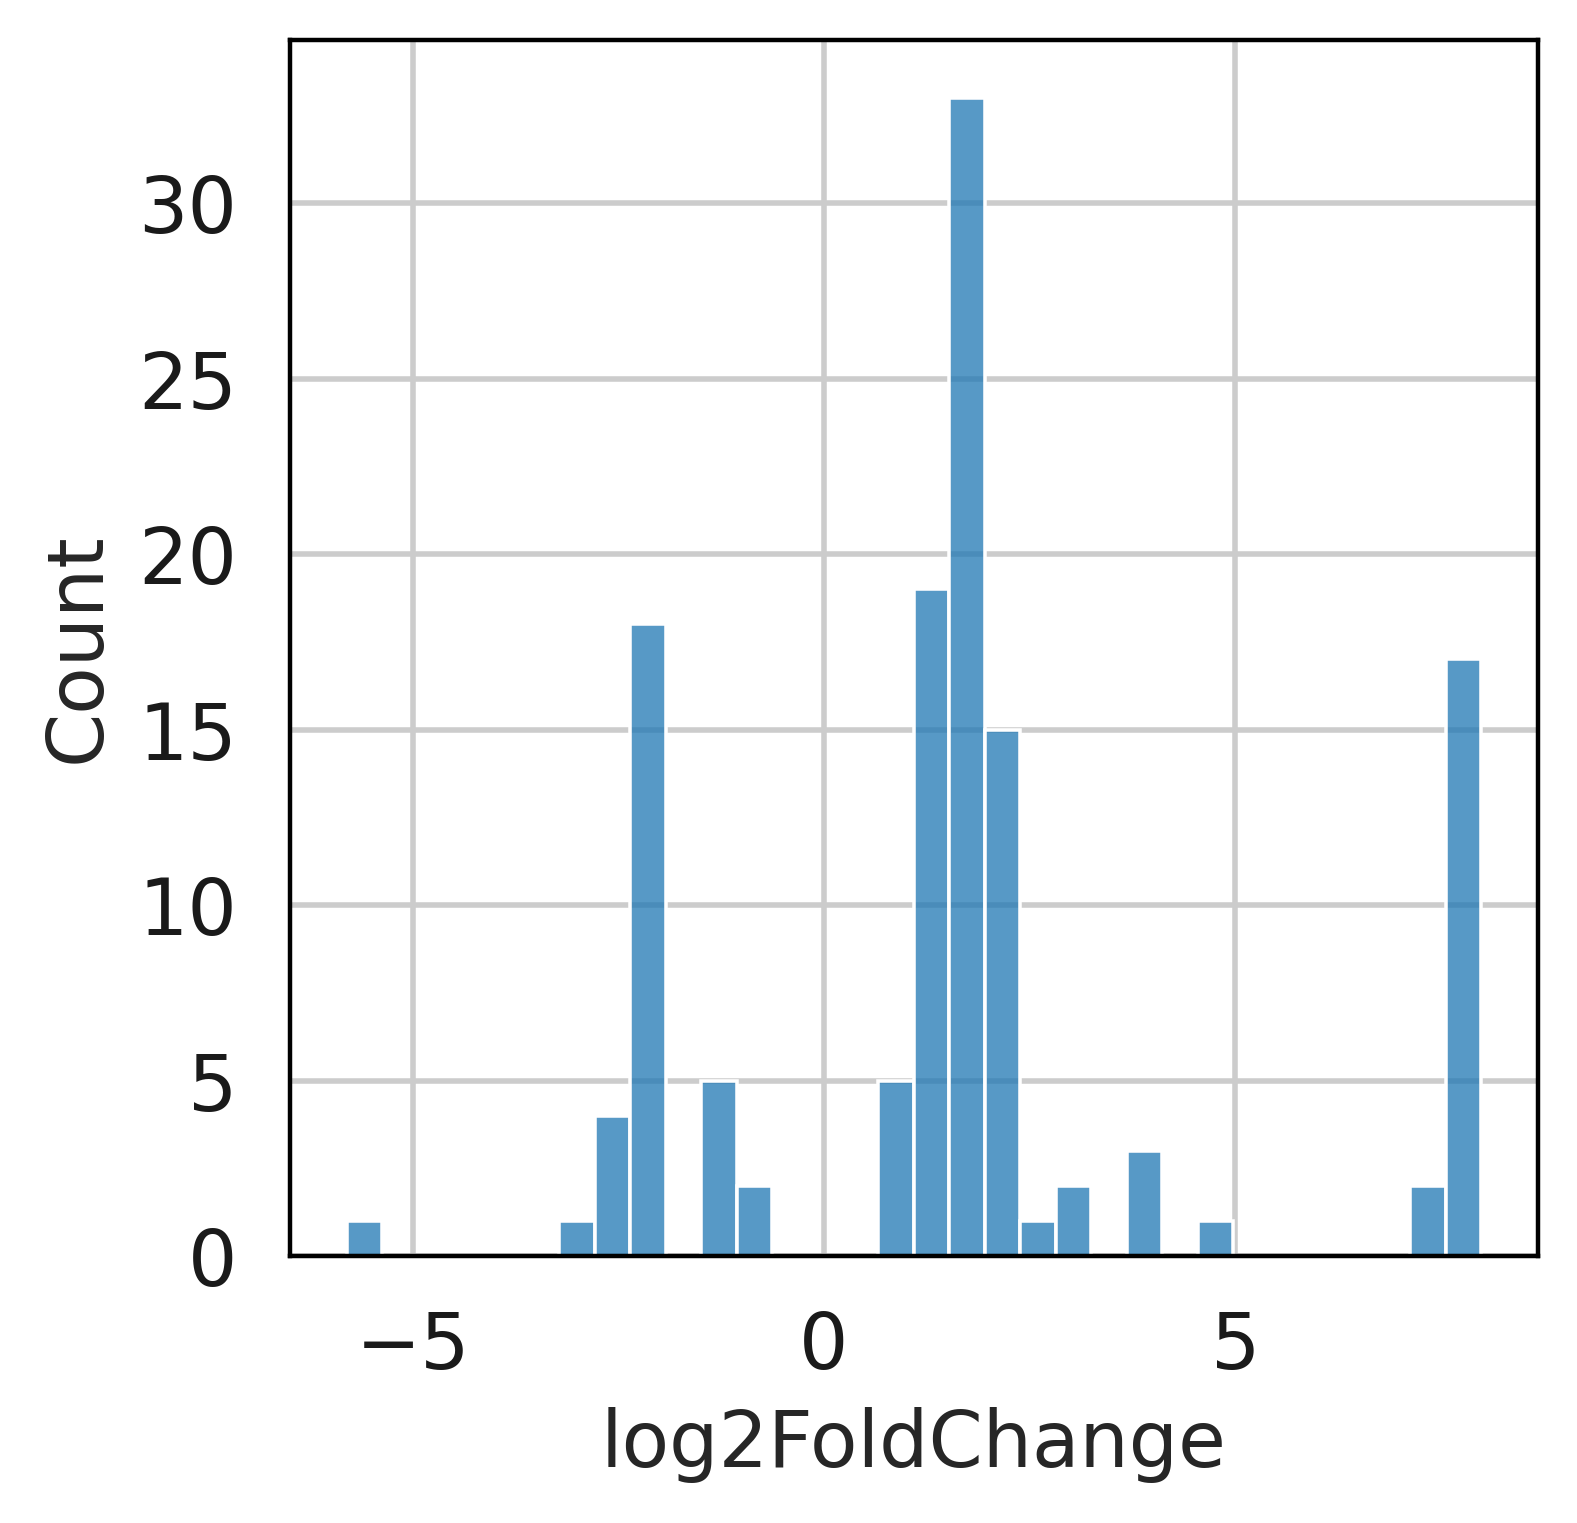

In [50]:
import seaborn as sns
sns.histplot(data=cpdb_sig_int_unique, x="log2FoldChange")

In [59]:
adata.uns["rank_aggregate"].columns

Index(['source', 'target', 'ligand_complex', 'receptor_complex', 'lr_means',
       'cellphone_pvals', 'expr_prod', 'scaled_weight', 'lr_logfc',
       'spec_weight', 'lrscore', 'lr_probs', 'cellchat_pvals',
       'specificity_rank', 'magnitude_rank'],
      dtype='object')

/home/kvalem/.conda/envs/liana_2024/lib/python3.11/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


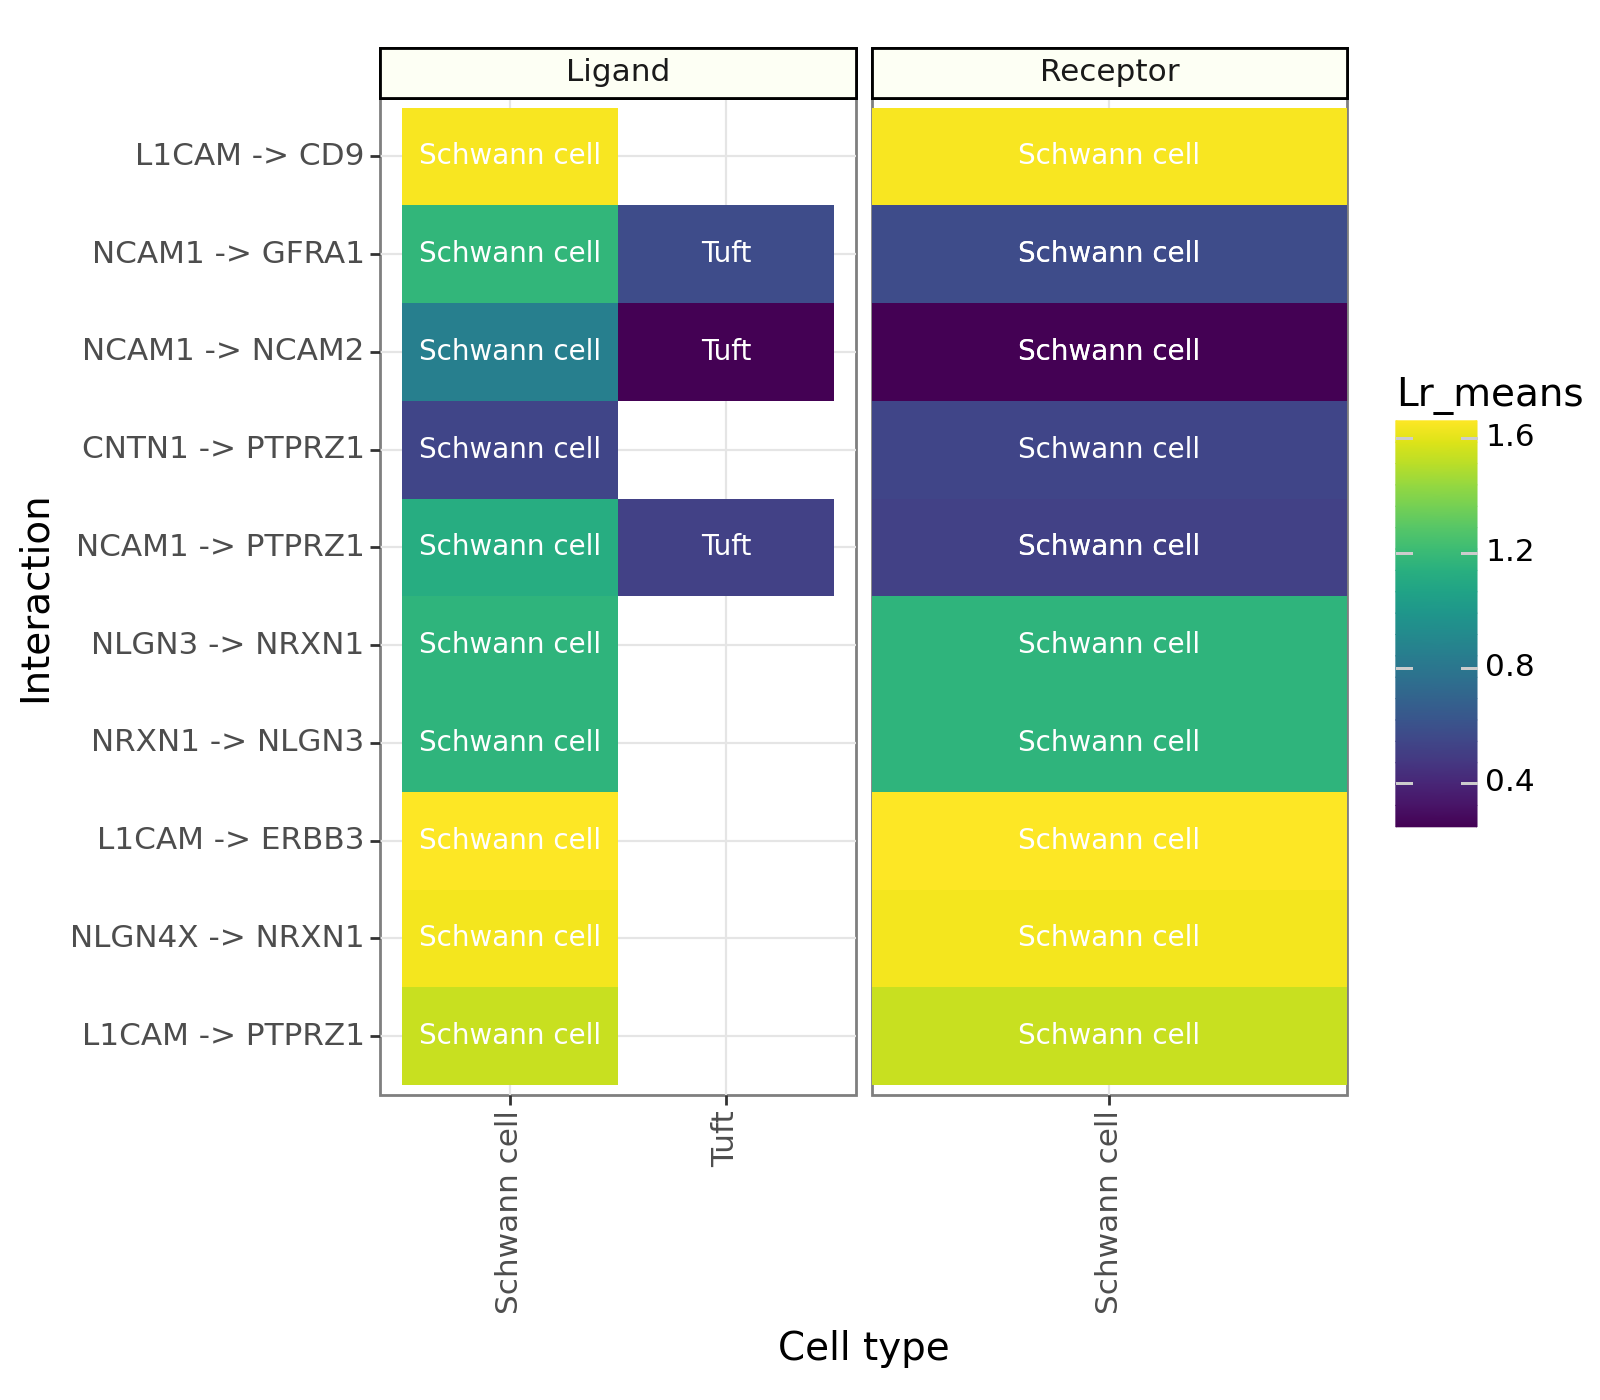

<Figure Size: (800 x 700)>

In [63]:
my_plot = li.pl.tileplot(adata = adata,
                         # NOTE: fill & label need to exist for both
                         # ligand_ and receptor_ columns
                         fill='lr_means',
                         label='cell_type',
                         top_n=10,
                         orderby='specificity_rank',
                         orderby_ascending=True,
                         source_labels=['Neutrophil', 'Schwann cell', 'Tuft'],
                         target_labels=['Neutrophil', 'Schwann cell', ],
                         uns_key='rank_aggregate', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


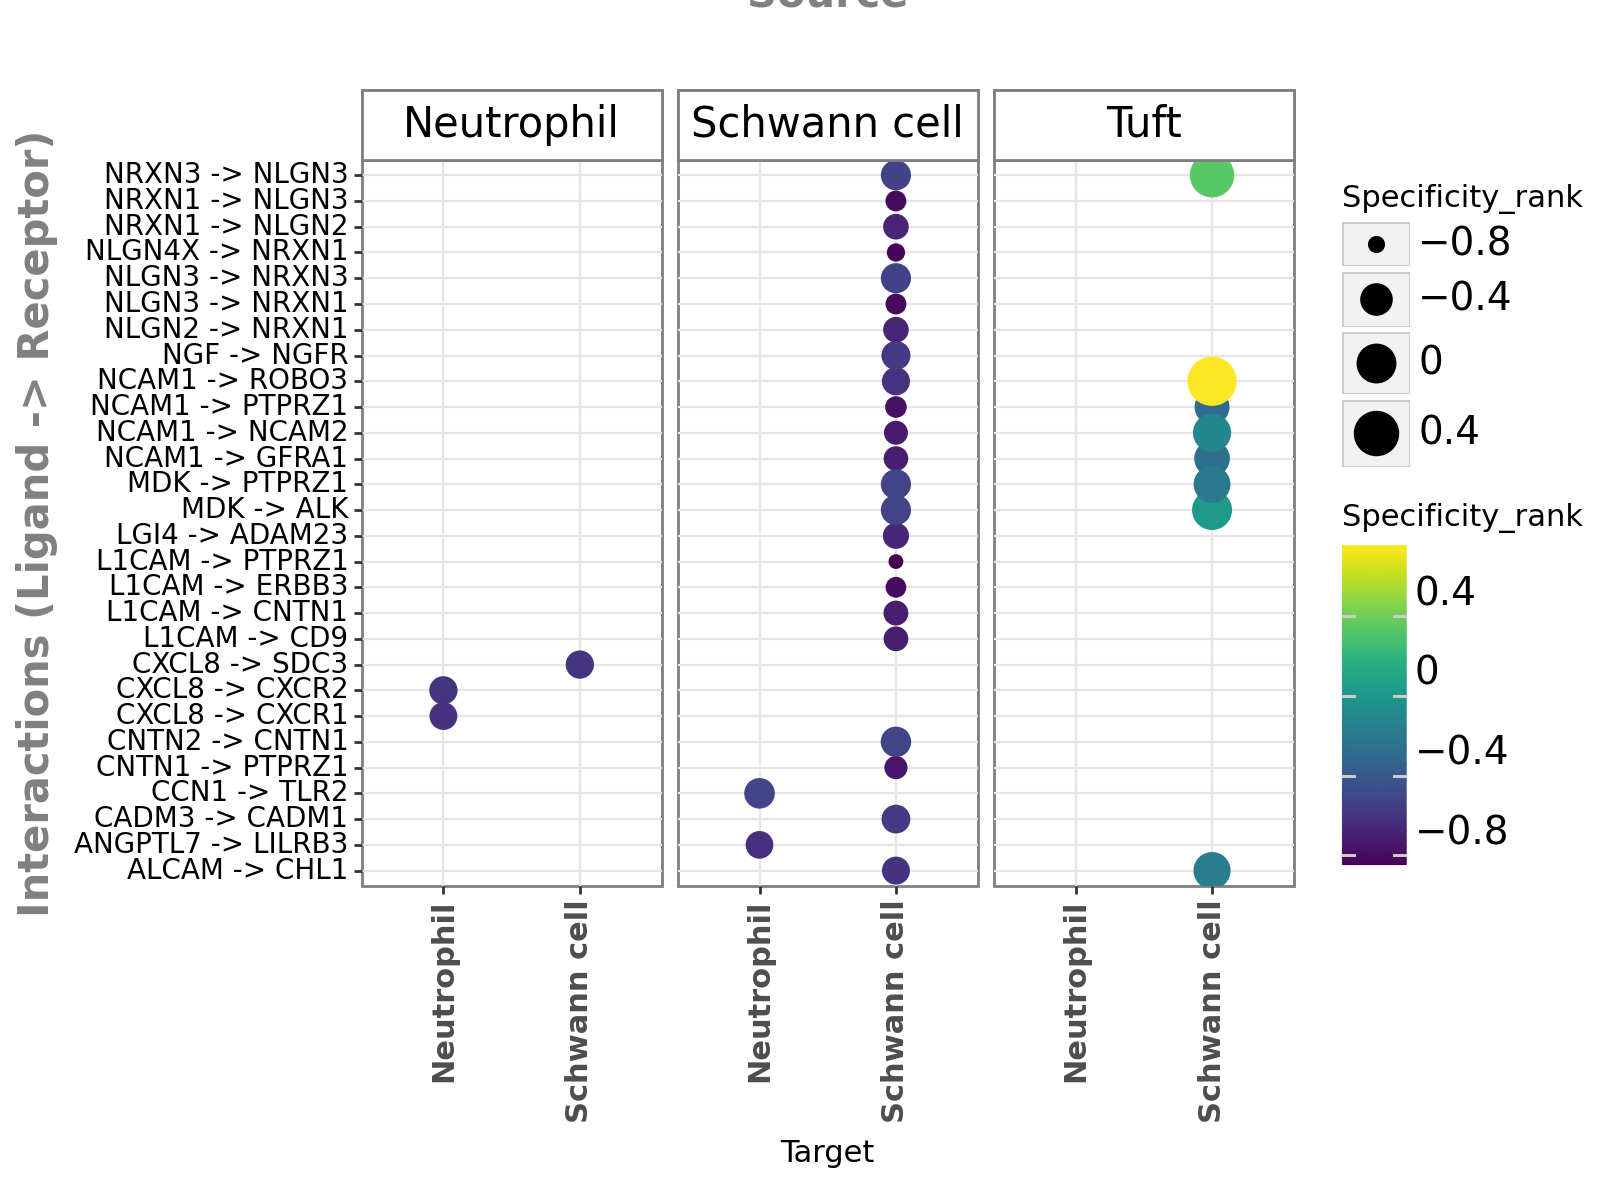

<Figure Size: (800 x 600)>

In [65]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='specificity_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['Neutrophil', 'Schwann cell', 'Tuft'],
                         target_labels=['Neutrophil', 'Schwann cell', ],
                        filter_fun=lambda x: x['specificity_rank'] <= 0.001,
                            uns_key='rank_aggregate', # NOTE: default is 'liana_res'
                       )
my_plot

In [48]:
cpdb_sig_int.to_csv(f"{resDir}/epithelial_cancer_unique.csv")

## 07. Cell-cell interactions heatmap 

In [ ]:
immune_cells= [
    "Cancer cell",
    "B cell",
    "Endothelial",
    "DC mature",
    "Macrophage",
    "Mast cell",
    "Monocyte",
    "NK",
    "Neutrophil",
    "Plasma cell",
    "T cell CD4",
    "T cell CD8",
    "T cell regulatory",
    "cDC",
    "pDC",
]

In [ ]:
cpdb_sig_int = cpdb_sig_int.loc[lambda x: x["cell_type_fine"].isin(immune_cells)]

In [ ]:
top_genes = (
    cpdb_sig_int.loc[:, ["source_genesymbol", "fdr"]]
    .drop_duplicates()
    .sort_values("fdr")["source_genesymbol"][:30]
    .tolist()
)

In [ ]:
title_plot = f"{perturbation} vs {baseline}: {cell_type_oi}, FDR<0.1"

In [ ]:
save_name_plot =  f"{perturbation}_vs_{baseline}_{cell_type_oi}_fdr_0.1"

In [ ]:
heatmap = cpdba.plot_result(
    cpdb_sig_int.loc[lambda x: x["source_genesymbol"].isin(top_genes)],
    title=title_plot,
    aggregate=False,
    cluster="heatmap",
    label_limit=110,
)
heatmap

In [ ]:
heatmap.save(f'{resDir}/figures/{save_name_plot}.png')
heatmap.save(f'{resDir}/figures/{save_name_plot}.svg')
heatmap.save(f'{resDir}/figures/{save_name_plot}.pdf')